# Домашняя работа №1

In [2]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def plot_one_image(image: np.ndarray) -> None:
    """
    Отобразить изображение с помощью matplotlib.
    Вспомогательная функция.
    
    :param image: изображение для отображения
    :return: None
    """
    fig, axs = plt.subplots(1, 1, figsize=(8, 7))
    
    axs.imshow(image)
    axs.axis('off')
    plt.plot()

# Задача №1 - Лабиринт

Реализуйте алгоритм поиска выхода из лабиринта по растровому изобажению.
Вам нужно написать код, который будет находить путь (координаты пикселей) от заданного входа сверху до выхода снизу.

Отрисуйте получившийся маршрут на карте с помощью функции ```plot_maze_path(img, coords)``` или воспользуйтесь вам известным графическим инструментом.

__Input:__

Изображение лабиринта в кодировке $RGB$.

Все карты лежат на [яндекс-диске](https://yadi.sk/d/qEWVZk2picDdZw)

__Ouput:__

Массив координат пути через лабиринт в виде ```(np.array(x), np.array(y))```. 

Оценивается __каждое__ успешное решение лабиринта.
Пример решенной задачи.<img src="https://b.radikal.ru/b22/1906/56/df991f2221a7.png" width="300">

In [3]:
def find_way_from_maze(image: np.ndarray) -> tuple:
    """
    Найти путь через лабиринт.

    :param image: изображение лабиринта
    :return: координаты пути из лабиринта в виде (x, y), где x и y - это массивы координат
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    cur_pos = (0, 0)
    while gray_image[cur_pos] != 255:
        cur_pos = (cur_pos[0], cur_pos[1] + 1)
    
    turn_matrix = np.full(gray_image.shape, np.inf)
    
    do_next_turn(gray_image, turn_matrix, cur_pos, -1)

    return repare_path(turn_matrix)


def do_next_turn(image: np.ndarray, turn_matrix: np.ndarray, cur_pos: tuple[int, int], cur_turn: int) -> None:
    size_y, size_x = turn_matrix.shape
    y, x = cur_pos

    if image[cur_pos] == 0:
        return
    
    if turn_matrix[cur_pos] != np.inf:
        return
    
    turn_matrix[cur_pos] = cur_turn + 1
    
    for i in range(-1, 2):
        for j in range(-1, 2):
            if ((0 <= (x + i) < size_x) and (0 <= (y + j) < size_y)):
                pos = (y + j, x + i)
                do_next_turn(image, turn_matrix, pos, cur_turn + 1)


def repare_path(turn_matrix):
    size_y, size_x = turn_matrix.shape

    cur_pos = turn_matrix.shape
    cur_pos = (turn_matrix.shape[0] - 1, 0)
    while turn_matrix[cur_pos] == np.inf:
        cur_pos = (cur_pos[0], cur_pos[1] + 1)
    
    coords = [[cur_pos[0]], [cur_pos[1]]]
    while turn_matrix[cur_pos] != 0:
        y, x = cur_pos
        flag = False
        for i in range(-1, 2):
            for j in range(-1, 2):
                if ((0 <= (x + i) < size_x) and (0 <= (y + j) < size_y)):
                    pos = (y + j, x + i)
                    if turn_matrix[pos] < turn_matrix[cur_pos]:
                        cur_pos = pos
                        flag = True
                        break
            if flag:
                break
        
        coords[0].append(pos[0])
        coords[1].append(pos[1])
    
    return coords

In [4]:
def plot_maze_path(image: np.ndarray, coords: tuple) -> np.ndarray:
    """
    Нарисовать путь через лабиринт на изображении. 
    Вспомогательная функция.
     
    :param image: изображение лабиринта
    :param coords: координаты пути через лабиринт типа (x, y) где x и y - массивы координат точек
    :return img_wpath: исходное изображение с отрисованными координатами 
    """
    if image.ndim != 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
    img_wpath = image.copy()
    if coords:
        x, y = coords
        img_wpath[x, y, :] = [0, 0, 255]

    return img_wpath

Загрузим тестовое изображение и отобразим его.

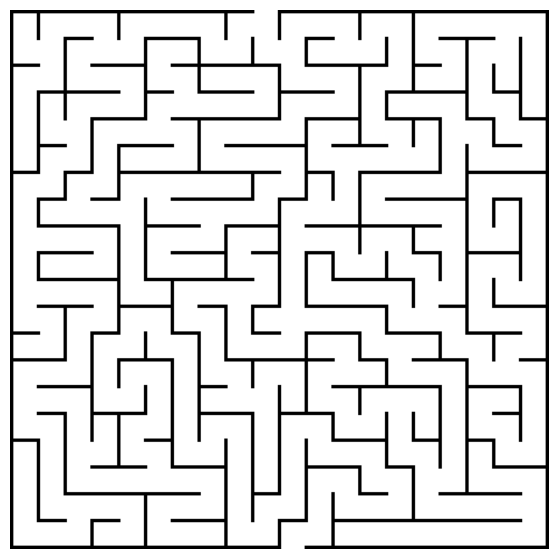

In [5]:
test_image = cv2.imread('task_1/20 by 20 orthogonal maze.png')  # загрузить тестовую картинку

plot_one_image(test_image)

Теперь ваша задача реализовать функцию ```plot_maze_path``` в ```task_1.py``` для того, чтобы найти координаты пути через лабиринт.

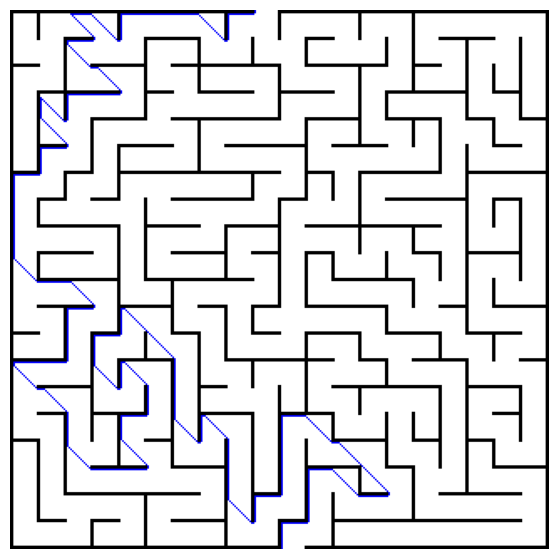

In [6]:
from sys import setrecursionlimit
setrecursionlimit(100_000)

way_coords = find_way_from_maze(test_image)  # вычислить координаты пути через лабиринт

image_with_way = plot_maze_path(test_image, way_coords)

plot_one_image(image_with_way)

# Задача №2 - Пробки в городе

Требуется написать программу, которая на вход принимает картинку, на которой схематически изображена машинка на дороге с $N$ полосами и препятствия на полосах. Соответствующие объекты обозначены цветами, которые сохраняются на всех изображениях. 

Результатом работы программы является номер полосы, на которую нужно перестроиться или сообщение о том, что перестраиваться не нужно.

**Примечание: номер дороги считается слева направо, отсчет начинается с нуля.**

Примеры изображений:
<table><tr>
    <td> <img src="https://i.ibb.co/8z84sJG/image_00.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/Z6m4XFz/image_01.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [109]:
def find_road_number(image: np.ndarray) -> int:
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lanes_info = find_lanes(image_hsv)

    car_lane = find_car(lanes_info)
    free_lane = find_free_lane(image_hsv, lanes_info)

    return free_lane if car_lane != free_lane else "Перестраиваться не нужно"


def find_lanes(image_hsv: np.ndarray) -> list[np.ndarray]:
    lane_low = (20, 50, 50)
    lane_high = (40, 250, 255)

    lane_mask = cv2.inRange(image_hsv, lane_low, lane_high)
    lane_indeces = []

    i = 0
    while i < lane_mask.shape[1]:
        elem = lane_mask[0][i]
        if elem: 
            i += 1
            continue

        lane_indeces.append(i)
        while not elem:
            i += 1
            elem = lane_mask[0][i]
        lane_indeces.append(i)
    
    return np.hsplit(image_hsv, lane_indeces)[1::2]


def find_car(lanes_info: list[np.ndarray]) -> int:
    car_low = (100, 50, 50)
    car_high = (120, 250, 255)

    for i in range(len(lanes_info)):
        lane = lanes_info[i]
        car_mask = cv2.inRange(lane, car_low, car_high)
        if np.any(car_mask):
            return i

    return -1


def find_free_lane(image_hsv: np.ndarray, lanes_info: np.ndarray) -> int:
    barrier_low = (0, 50, 50)
    barrier_high = (10, 250, 255)

    for i in range(len(lanes_info)):
        lane = lanes_info[i]
        barrier_mask = cv2.inRange(lane, barrier_low, barrier_high)
        if np.any(barrier_mask):
            continue

        return i

    return -1


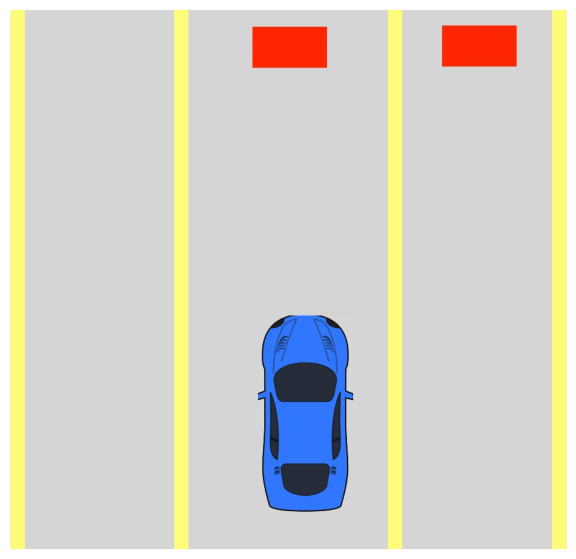

In [115]:
test_image = cv2.imread('task_2/image_02.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plot_one_image(test_image)

In [116]:
road_number = find_road_number(test_image)

print(f'Нужно перестроиться на дорогу номер {road_number}')

Нужно перестроиться на дорогу номер 0


# Задача №3 - Аффинные преобразования

## Задача №3.1 - Поверни изображение

Реализуйте функцию, которая поворачивает изображение вокруг заданной точки на заданный угол ($0^\circ-360^\circ$) и преобразует размер изображения, чтобы оно не обрезалось после поворота.

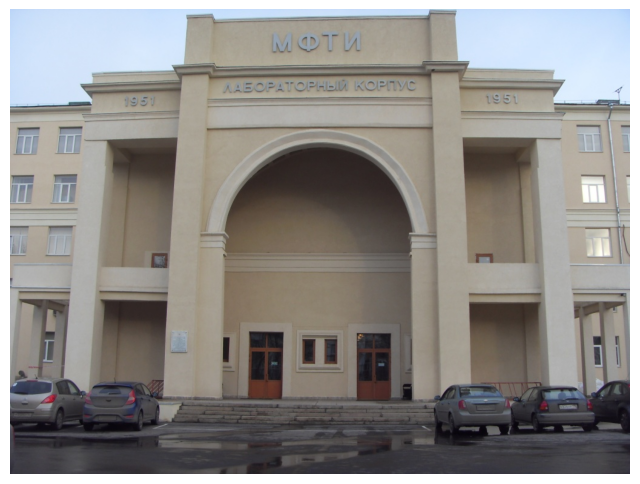

In [214]:
test_image = cv2.imread('task_3/lk.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plot_one_image(test_image)

[ 17.03708686 129.40952255] [1006.14513298 -135.62117963] [215.81011349 871.24055714] [1204.91815961  606.20985496] [  17.03708686 -135.62117963] [1204.91815961  871.24055714]


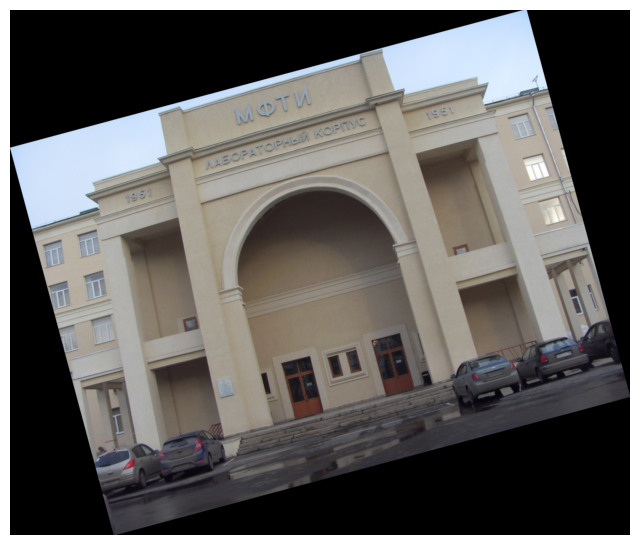

In [417]:
def rotate(image, point: tuple, angle: float) -> np.ndarray:
    """
    Повернуть изображение по часовой стрелке на угол от 0 до 360 градусов и преобразовать размер изображения.

    :param image: исходное изображение
    :param point: значение точки (x, y), вокруг которой повернуть изображение
    :param angle: угол поворота
    :return: повернутное изображение
    """
    # Ваш код
    h, w, _ = image.shape
    x, y = point

    r1 = np.array((0, 0, 1)).T
    r2 = np.array((w, 0, 1)).T
    r3 = np.array((0, h, 1)).T
    r4 = np.array((w, h, 1)).T

    M1 = cv2.getRotationMatrix2D((x, y), angle, scale=1.0)

    r1 = np.array(M1) @ r1
    r2 = np.array(M1) @ r2
    r3 = np.array(M1) @ r3
    r4 = np.array(M1) @ r4

    mx = np.max([r1, r2, r3, r4], axis=0)
    mn = np.min([r1, r2, r3, r4], axis=0)
    print(r1, r2, r3, r4, mn, mx)

    scale = mx - mn

    M1 = cv2.getRotationMatrix2D((x, y), angle, scale=1.0)
    M1[0, 2] -= mn[0]
    M1[1, 2] -= mn[1]

    image = cv2.warpAffine(image, M1, (int(scale[0]), int(scale[1])))

    return image


def apply_warpAffine(image, points1, points2) -> np.ndarray:
    """
    Применить афинное преобразование согласно переходу точек points1 -> points2 и
    преобразовать размер изображения.

    :param image:
    :param points1:
    :param points2:
    :return: преобразованное изображение
    """

    return image

h, w, _ = test_image.shape
test_point = (500, 0)
test_angle = 15

transformed_image = rotate(test_image, test_point, test_angle)
plot_one_image(transformed_image)

Проверьте как это должно было получиться

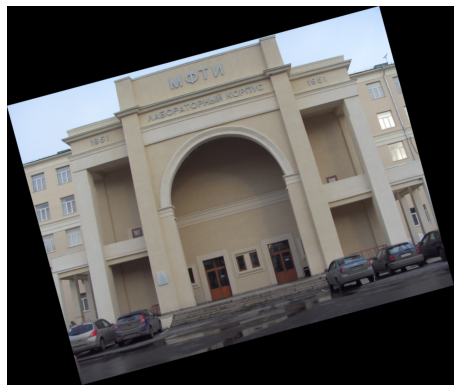

In [8]:
result_image = cv2.imread('task_3/lk_rotate.jpg')
result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
plot_one_image(result_image)

## Задача №3.2 - Афинные преобразования

Реализуйте прототип программы, которая помогает сканировать документы с помощью приложения на телефоне.

<img src="task_3/adobe_scan.jpg"/>

Данная программа берёт изображение, находит углы листа и приводит документ к виду с вертикальной проекцией с помощью афинных преобразований.

В данной задаче предлагается обработать фото тетради, найдя её углы с помощью поиска по цвету.

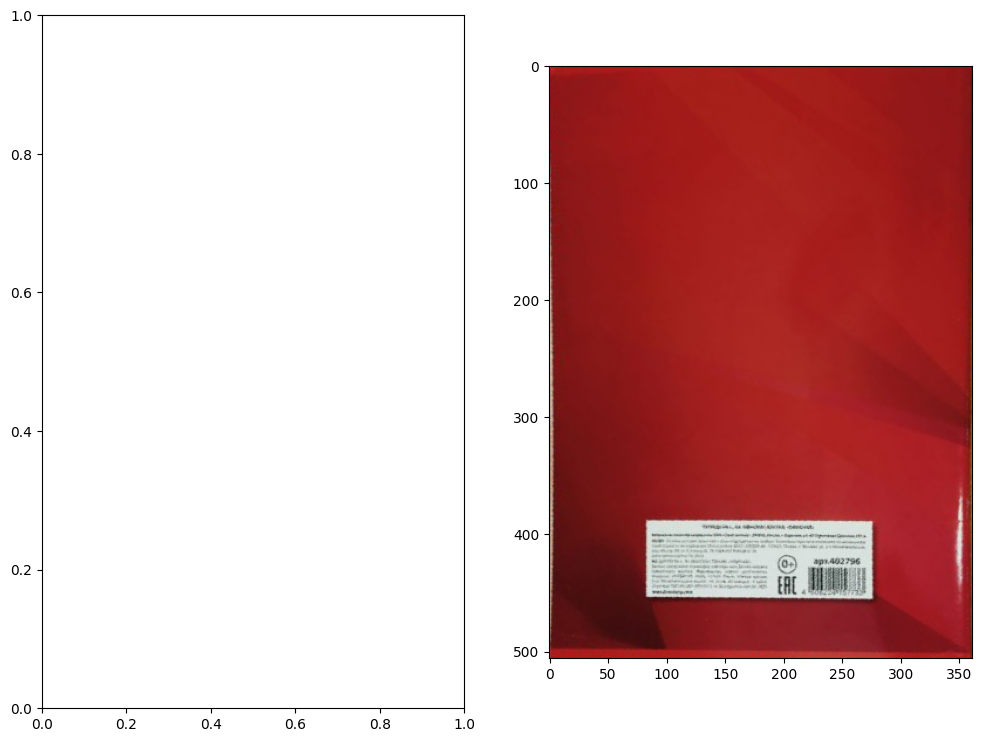

In [ ]:
def get_mask(image_hsv):
    notebook_low = (0, 50, 50)
    notebook_high = (5, 250, 255)

    return cv2.inRange(image_hsv, notebook_low, notebook_high)

def get_anchor_points(mask):
    indices = np.argwhere(mask == 255)
    anchor_ind = *np.argmax(indices, axis=0), *np.argmin(indices, axis=0)
    anchor = map(lambda x: indices[x][::-1], anchor_ind)
    
    return np.float32(list(anchor))

def normalize_image(image_rgb):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask = get_mask(image_hsv)
    anchor = get_anchor_points(mask)

    size = np.linalg.norm(anchor[3] - anchor[0]), np.linalg.norm(anchor[1] - anchor[0])
    new_points = np.float32([[size[0], size[1]], [size[0], 0], [0, 0], [0, size[1]]])

    M1 = cv2.getPerspectiveTransform(anchor, new_points)

    normalized_image = cv2.warpPerspective(image, M1, (int(size[0]), int(size[1])))

    return normalized_image


fig, m_axs = plt.subplots(1, 2, figsize = (12, 9))
ax1, ax2 = m_axs
image = cv2.imread('task_3/notebook.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
dst = normalize_image(image)

ax2.imshow(dst)

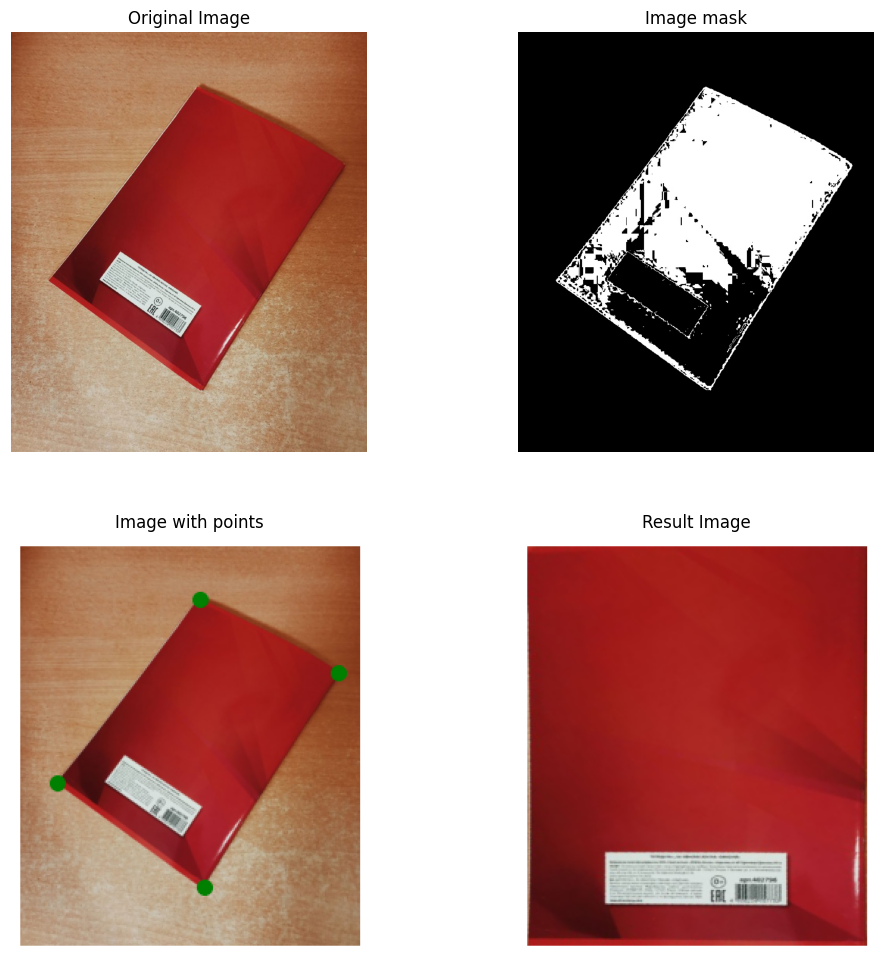

In [22]:
image = cv2.imread('task_3/notebook.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_mask = cv2.imread('task_3/notebook_mask.jpeg')
image_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2RGB)

image_points = cv2.imread('task_3/notebook_points.png')
image_points = cv2.cvtColor(image_points, cv2.COLOR_BGR2RGB)

image_result = cv2.imread('task_3/notebook_result.png')
image_result = cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')    

plt.subplot(2, 2, 2)
plt.title("Image mask")
plt.imshow(image_mask, cmap="gray")
plt.axis('off')  

plt.subplot(2, 2, 3)
plt.title("Image with points")
plt.imshow(image_points)
plt.axis('off')  

plt.subplot(2, 2, 4)
plt.title("Result Image")
plt.imshow(image_result)
plt.axis('off')  

plt.show()